## Мандрикова Анастасия
## Отчет-3 к зачету

In [1]:
library(ggplot2)
library(ggpubr)
library(cowplot)
library(Rssa)
library(tseries)
library(forecast)
library(urca)
library(TTR)
library(dplyr)
library(tidyr)
library(gdata)
library(lattice)

Warning message:
"package 'ggplot2' was built under R version 4.0.5"
Warning message:
"package 'ggpubr' was built under R version 4.0.5"
Warning message:
"package 'cowplot' was built under R version 4.0.5"

Attaching package: 'cowplot'


The following object is masked from 'package:ggpubr':

    get_legend


Loading required package: svd

Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: 'forecast'


The following object is masked from 'package:ggpubr':

    gghistogram



Attaching package: 'Rssa'


The following object is masked from 'package:stats':

    decompose


Warning message:
"package 'tseries' was built under R version 4.0.5"
Warning message:
"package 'dplyr' was built under R version 4.0.5"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, 

In [2]:
tser.align.center <- function(tser, len, def.val = NA) {
  len.diff <- len - length(tser)
  if (len.diff <= 0) {
    return(tser)
  }
  
  l.al <- len.diff %/% 2
  r.al <- len.diff - l.al
  c(rep(def.val, l.al), tser, rep(def.val, r.al))
}

tser.align.right <- function(tser, len, def.val = NA) {
  len.diff <- len - length(tser)
  if (len.diff <= 0) {
    return(tser)
  }
  
  c(rep(def.val, len.diff), tser)
}

tser.align.left <- function(tser, len, def.val = NA) {
  len.diff <- len - length(tser)
  if (len.diff <= 0) {
    return(tser)
  }
  
  c(tser, rep(def.val, len.diff))
}

tser.align <- function(tser, len, def.val = NA, type='center') {
  tser.len <- length(tser)
  len.diff <- len - tser.len
  if (len.diff <= 0) {
    return(tser)
  }
  
  switch(type, 'center'=tser.align.center, 'left'=tser.align.left, 'right'=tser.align.right)(tser, len, def.val)
}

tser.df.labelled.h <- function(lab, tser) {
  tser.len <- length(tser)
  as.data.frame(list(1:tser.len, as.numeric(tser), rep(lab, tser.len)), col.names = c("Index", "Values", "Labels"))
}

# for aligned series
tser.df.labelled <- function(tser.labs, ...) {
  Reduce(rbind, mapply(tser.df.labelled.h, tser.labs, list(...), SIMPLIFY = F, USE.NAMES = F))
}

tser.my.plot.h <- function(tser.df) {
  ggplot(data = tser.df) + geom_line(aes(x = Index, y = Values, col = Labels), alpha = 0.75)
}

tser.my.plot <- function(tser.orig, tser.trend, tser.season=NULL, plot.resid=T, plot.season=T, plot.reco=T,
                         component.labs=c("Trend", "Seasonal"), type.align='center', align.def.val=NA) {
  tser.trend.al <- tser.align(tser.trend, length(tser.orig))
  tser.resid <- tser.orig - tser.trend.al
  
  plot.list <- list(tser.my.plot.h(tser.df.labelled(c("Original", component.labs[1]), tser.orig, tser.trend.al)))

  if (!is.null(tser.season) && plot.season) {
    tser.season.al <- tser.align(tser.season, length(tser.orig))
    plot.list[[length(plot.list) + 1]] <- tser.my.plot.h(tser.df.labelled(c("Detrend", component.labs[2]), tser.resid, tser.season.al))
    tser.resid <- tser.resid - tser.season.al
  }
  
  if (!is.null(tser.season) && plot.reco) {
    tser.season.al <- tser.align(tser.season, length(tser.orig))
    plot.list[[length(plot.list) + 1]] <-  tser.my.plot.h(tser.df.labelled(c("Original", "Reconstructed"), tser.orig,
                                                                           tser.trend.al + tser.season.al))  
  }
  
  if (plot.resid) {
    plot.list[[length(plot.list) + 1]]<- tser.my.plot.h(tser.df.labelled(c("Residual"), tser.resid))
  }
  
  ggarrange(plotlist = plot.list, ncol = 1, nrow = length(plot.list), align = 'v')
}

## Gapfill/Igapfill
Рассмотрим задачу заполнения пропусков во временном ряду.

In [3]:
data <- read.table('LNU04035109.csv', sep=',', header=T, row.names = 1) 
data <- ts(data$LNU04035109, start = c(2000, 1), frequency = 12)

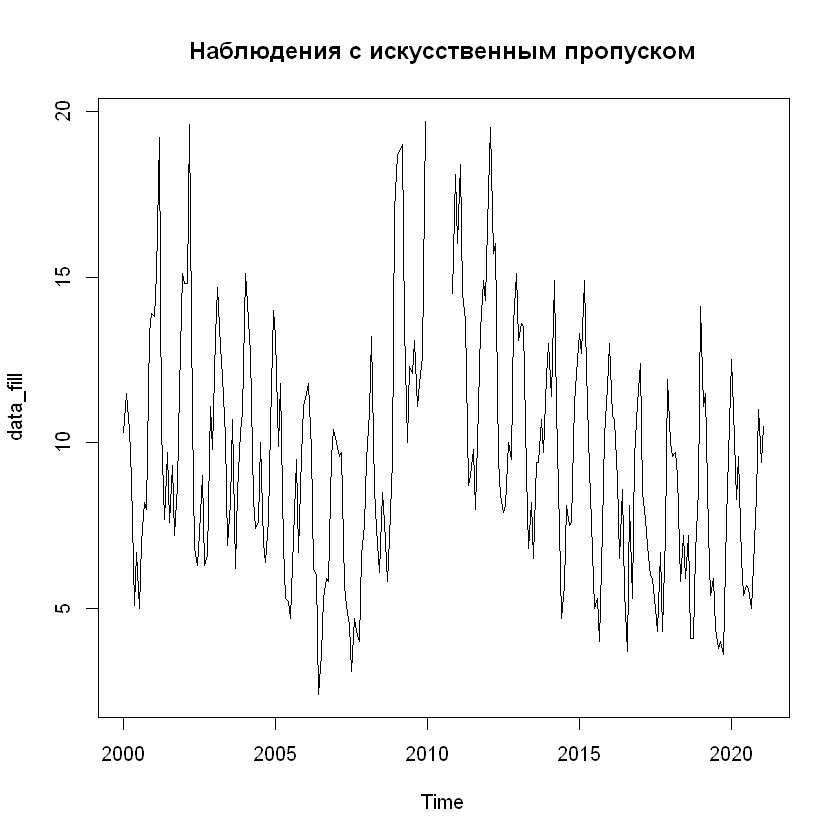

In [4]:
fill <- window(data, start = c(2010, 1), end =  c(2010, 10))
data_fill <- data
data_fill[121:130] <- NA
plot(data_fill, main = "Наблюдения с искусственным пропуском")

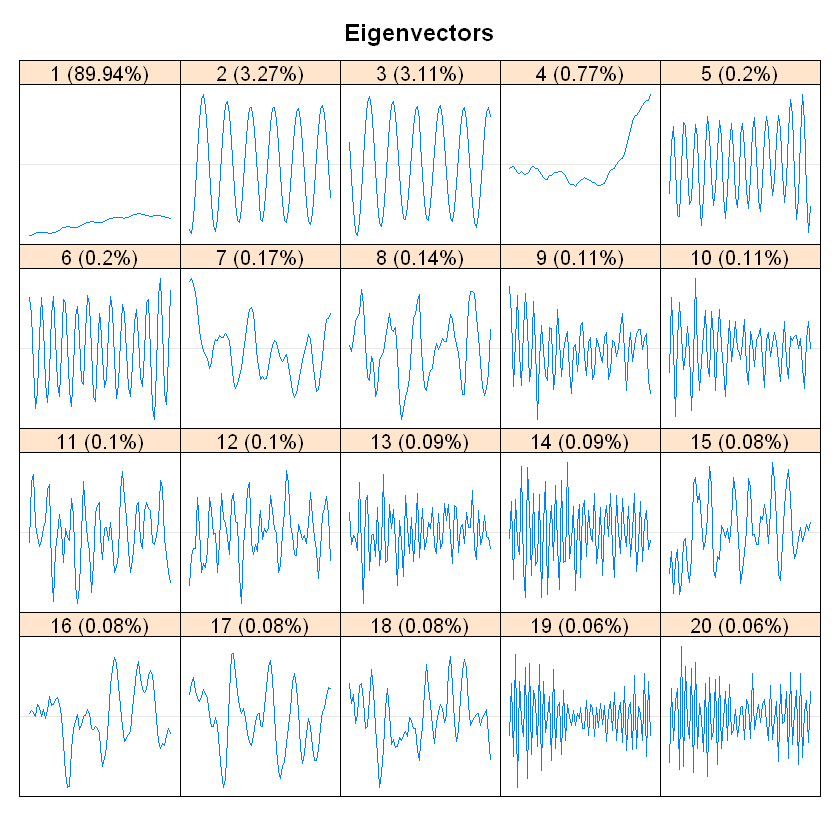

In [5]:
s <- ssa(data_fill, L = 72)
plot(s, type = 'vectors', idx = 1:20)

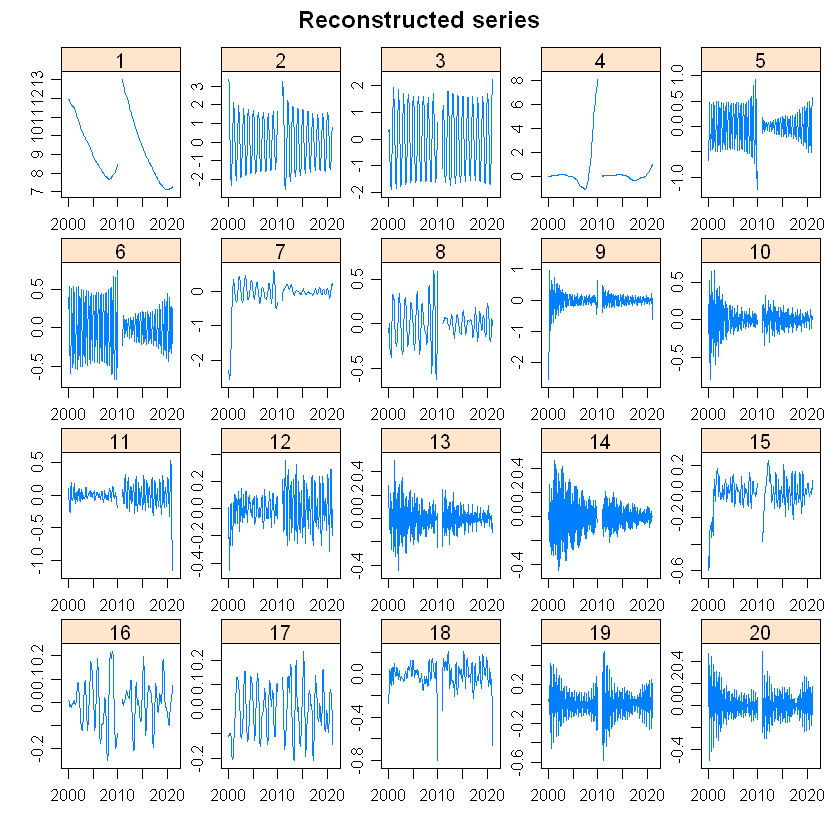

In [6]:
plot(s, type = 'series',  groups = as.list(1:20))

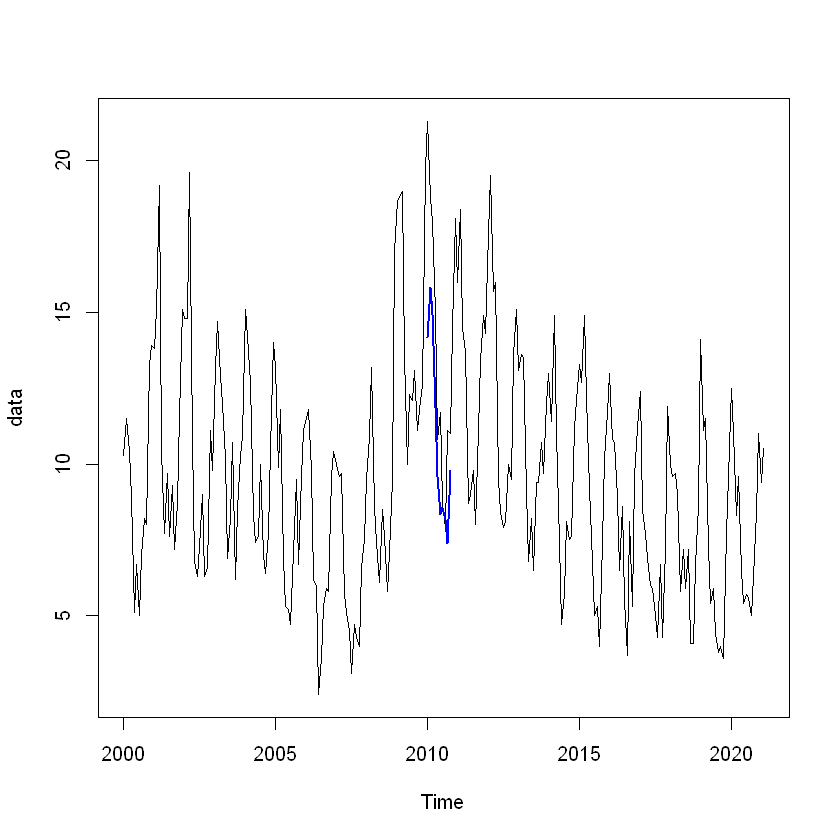

In [7]:
g <- gapfill(s, groups = list(c(1:18)), method = "sequential", alpha = 0.9, base = "reconstructed")
plot(data, col = "black")
lines(window(g, start = c(2010, 1), end =  c(2010, 10)), col = "blue", lwd = 2)

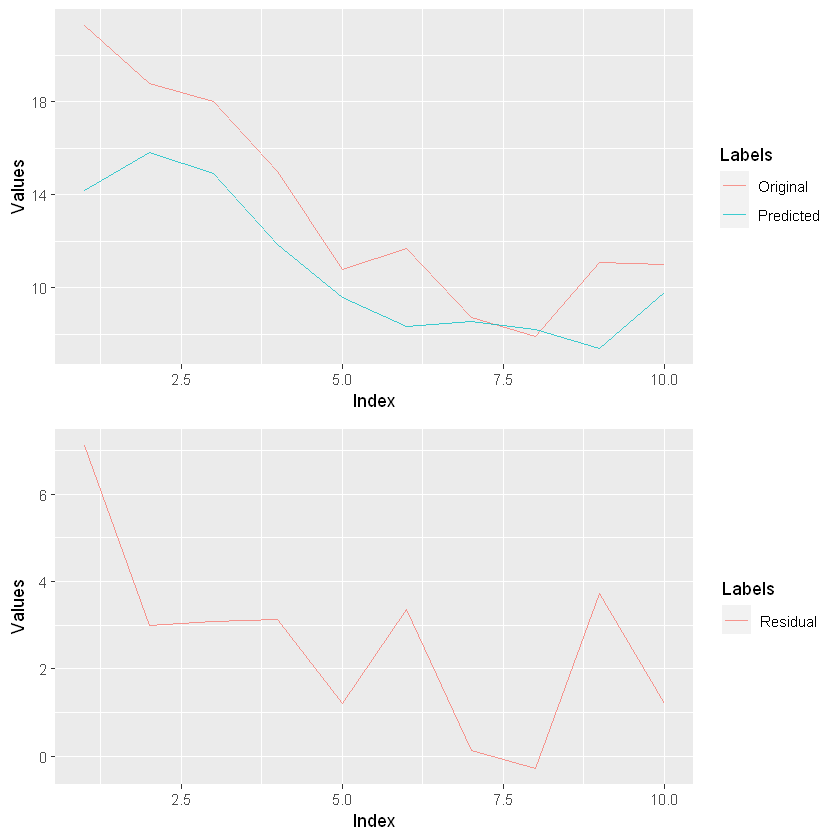

In [8]:
tser.my.plot(fill, window(g, start = c(2010, 1), end =  c(2010, 10)), component.labs = c("Predicted"))

Ошибка на train

In [9]:
res_gapfill1 <- window(data, start = c(2000, 1), end =  c(2010, 9)) - window(g, start = c(2000, 1), end =  c(2010, 9))
res_gapfill2 <- window(data, start = c(2010, 11), end =  c(2021, 2)) - window(g, start = c(2010, 11), end =  c(2021, 2))
mean(c(res_gapfill1^2, res_gapfill2^2))

[1] 1.440203

Ошибка на test

In [10]:
mean((fill - window(g, start = c(2010, 1), end =  c(2010, 10)))^2)

[1] 10.70116

Сравним с igapfill.

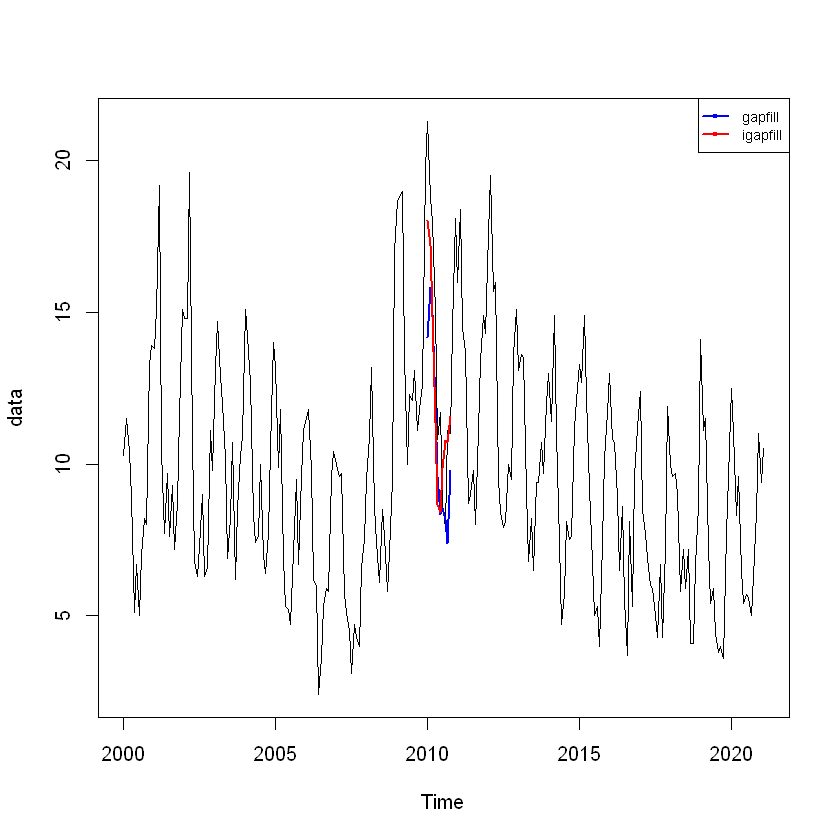

In [11]:
ig <- igapfill(s, groups = list(1:18), base = "original", maxiter = 5)
plot(data)
lines(window(g, start = c(2010, 1), end =  c(2010, 10)), col = "blue", lwd = 2)
lines(window(ig, start = c(2010, 1), end =  c(2010, 10)), col = "red", lwd = 2)
legend("topright", c("gapfill", "igapfill"), 
       col = c("blue", "red"), cex=0.7, pch=20, lwd = 2)

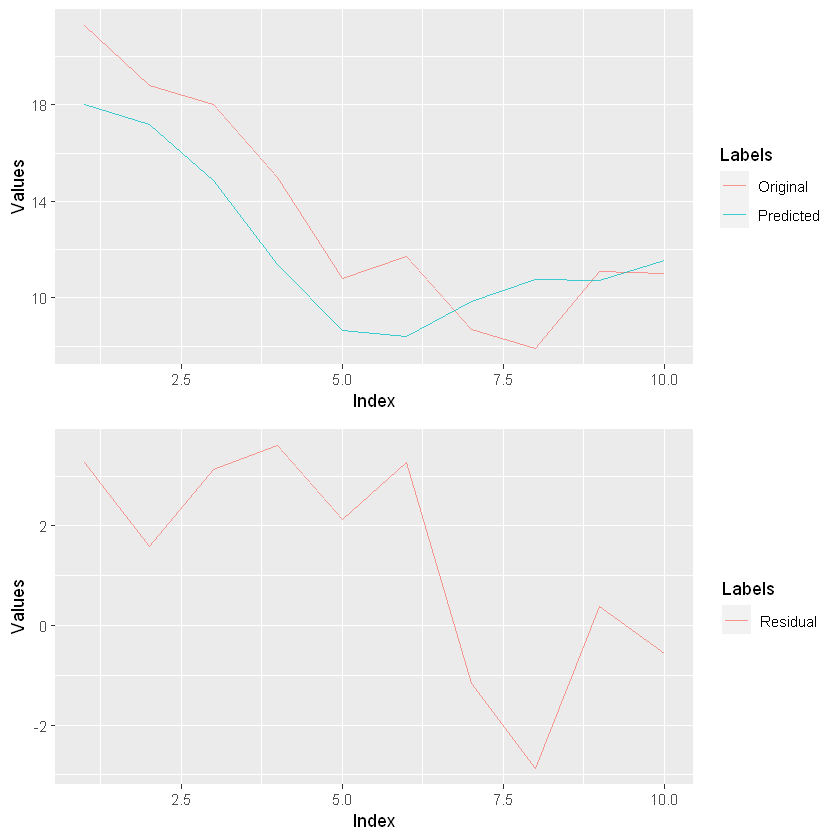

In [12]:
tser.my.plot(fill, window(ig, start = c(2010, 1), end =  c(2010, 10)), component.labs = c("Predicted"))

Ошибка на train:

In [13]:
res_igapfill1 <- window(data, start = c(2000, 1), end =  c(2010, 9)) - window(ig, start = c(2000, 1), end =  c(2010, 9))
res_igapfill2 <- window(data, start = c(2010, 11), end =  c(2021, 2)) - window(ig, start = c(2010, 11), end =  c(2021, 2))
mean(c(res_igapfill1^2, res_igapfill2^2))

[1] 0.2418744

Ошибка на test:

In [14]:
mean((fill - window(ig, start = c(2010, 1), end =  c(2010, 10)))^2)

[1] 6.15187

Видим, что результат igapfill лучше.

### Несколько пропусков

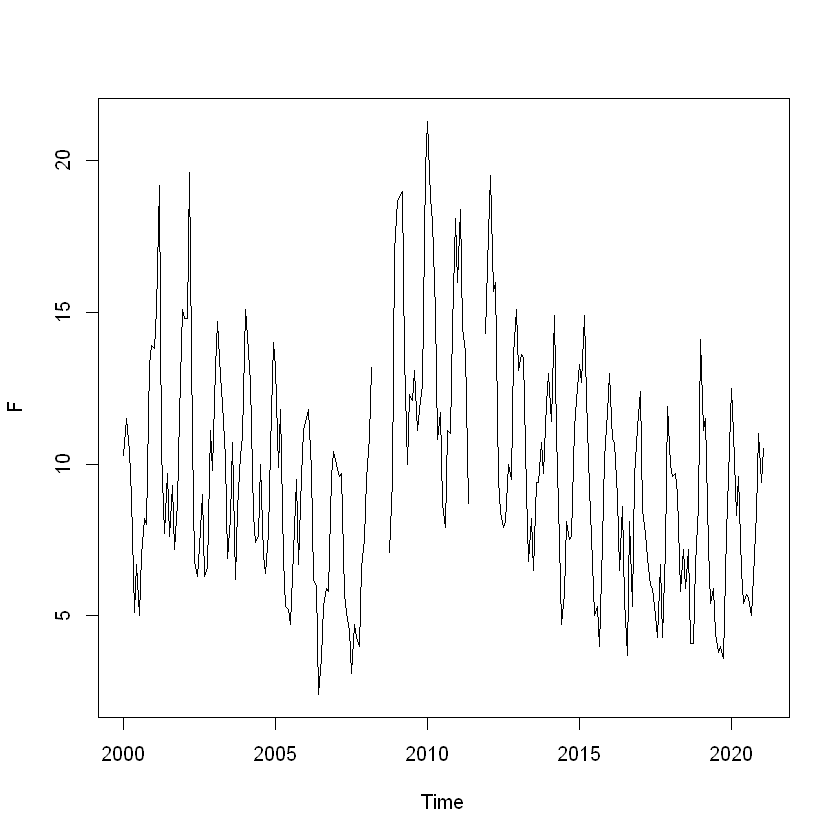

In [15]:
F <- data
loc <- c(100:105, 138:143)
F[loc] <- NA;
f <- data[loc]
plot(F)

Warning message in eval(.init.fragment(this)):
"Some field elements were not covered by shaped window. 32 elements will be ommited"


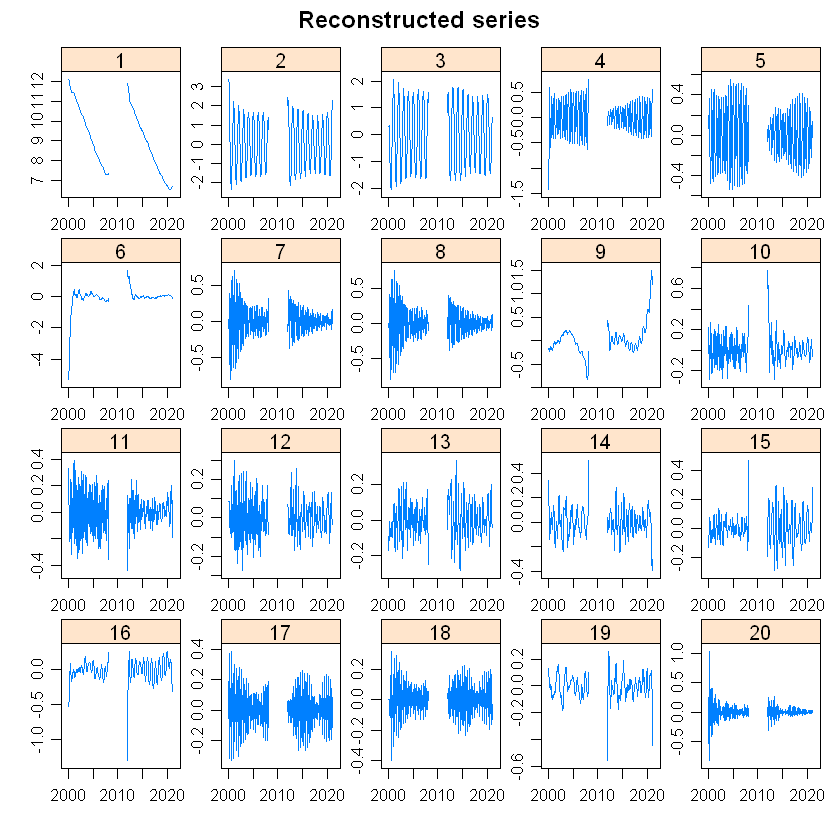

In [16]:
sr <- ssa(F, L = 72)
plot(sr, type = 'series',  groups = as.list(1:20))

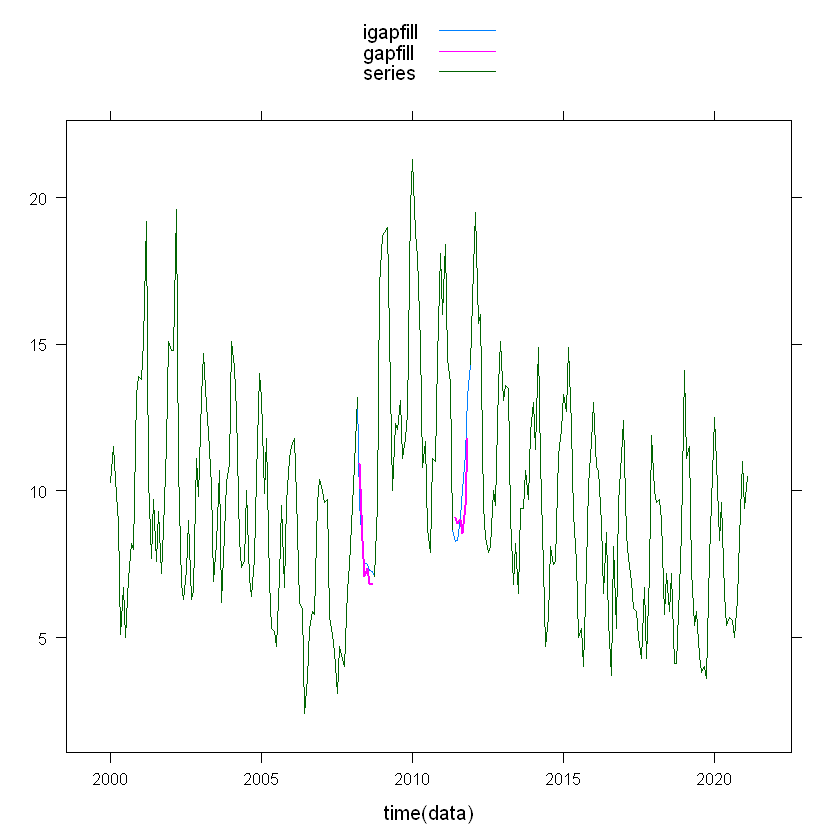

In [17]:
gr <- gapfill(sr, groups = list(c(1:16)), method = "simultaneous", base = "original")
igr <- igapfill(sr, groups = list(c(1:16)), base = "original", maxiter = 10)
G <- rep(NA, length(F)); G[loc] = gr[loc]

xyplot(igr + G + F ~ time(data), type = "l", 
       lwd = c(1, 2, 1), ylab = NULL,
       auto.key = list(lines = TRUE, points = FALSE, 
                    text = c("igapfill", "gapfill", "series")))

Ошибка gapfill:

In [18]:
mean((gr[loc] - data[loc])^2)

[1] 3.616446

Ошибка igapfill:

In [19]:
mean((igr[loc] - data[loc])^2)

[1] 1.606461

В данном случае тоже лучший результат показывает igapfill.

## 2d-SSA   
Вспомогательные пакеты и функции.

In [20]:
library("imager")
library("magick")

Warning message:
"package 'imager' was built under R version 4.0.5"
Loading required package: magrittr


Attaching package: 'magrittr'


The following object is masked from 'package:tidyr':

    extract



Attaching package: 'imager'


The following object is masked from 'package:magrittr':

    add


The following object is masked from 'package:tidyr':

    fill


The following object is masked from 'package:cowplot':

    draw_text


The following objects are masked from 'package:stats':

    convolve, spectrum


The following object is masked from 'package:graphics':

    frame


The following object is masked from 'package:base':

    save.image


Warning message:
"package 'magick' was built under R version 4.0.5"
Linking to ImageMagick 6.9.12.3
Enabled features: cairo, freetype, fftw, ghostscript, heic, lcms, pango, raw, rsvg, webp
Disabled features: fontconfig, x11



In [21]:
img2matrix <- function(image){
    mat = t(image[[1]][1,,])
    mode(mat) <- 'integer'
    mat
}

matrix2img <- function(matrix, col = 255){
    cimg2magick(as.cimg((matrix)/col), rotate = FALSE)
}

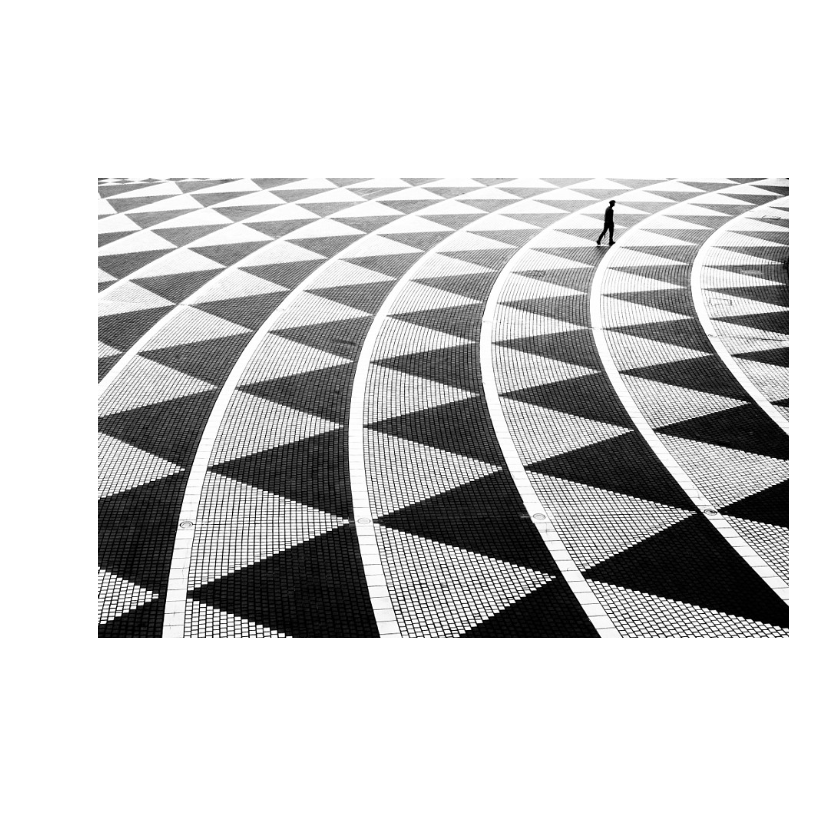

In [22]:
im <- image_read("example.jpg")
plot(im)

Поставим задачу: сгладить картинку, а именно попробовать убрать изображение мелкой квадратной плитки из узора. Так как это повторяющийся элемент структуры, необходимо выделить структурные компоненты. 

In [23]:
mat <- img2matrix(im)

In [24]:
s <- ssa(mat, kind = "2d-ssa", L = c(25, 25))

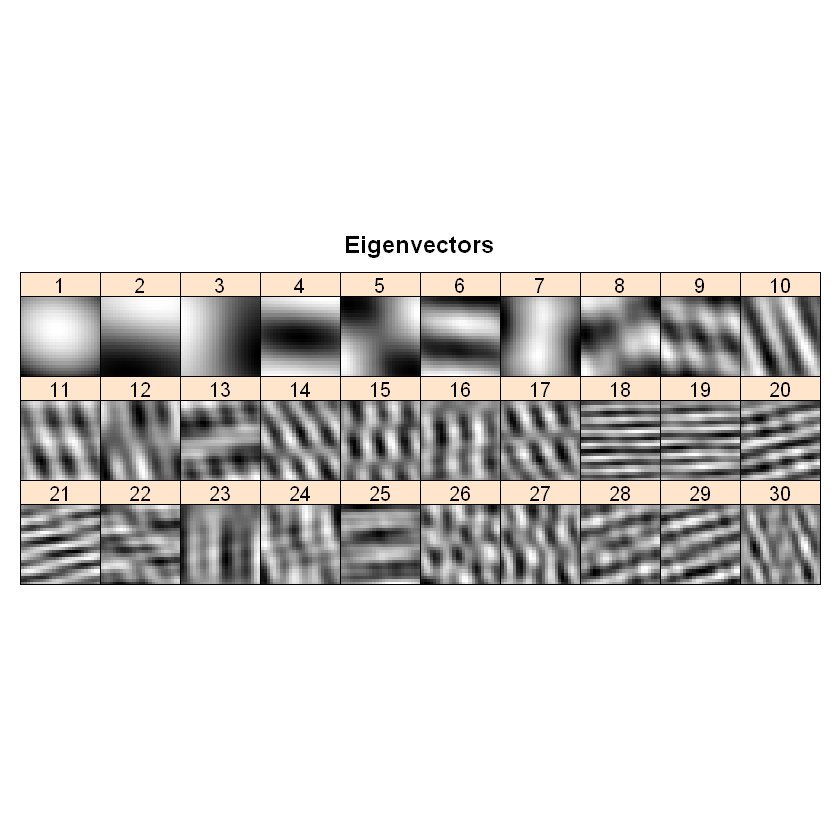

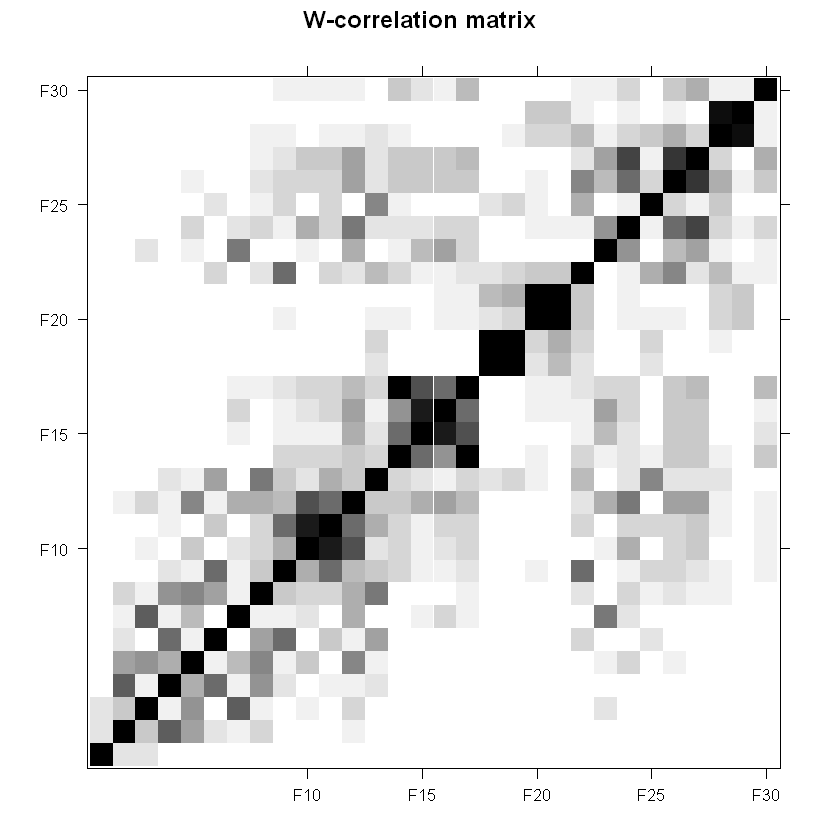

In [25]:
plot(s, type = "vectors", idx = 1:30, cuts = 255, layout = c(10, 3), plot.contrib = FALSE)
plot(wcor(s, groups = 1:30), scales = list(at = c(10, 15, 20, 25, 30)))

Четко увидеть структурные компоненты не получается. Ориентуруясь на график корреляций, уберем сильно связанные компоненты. 

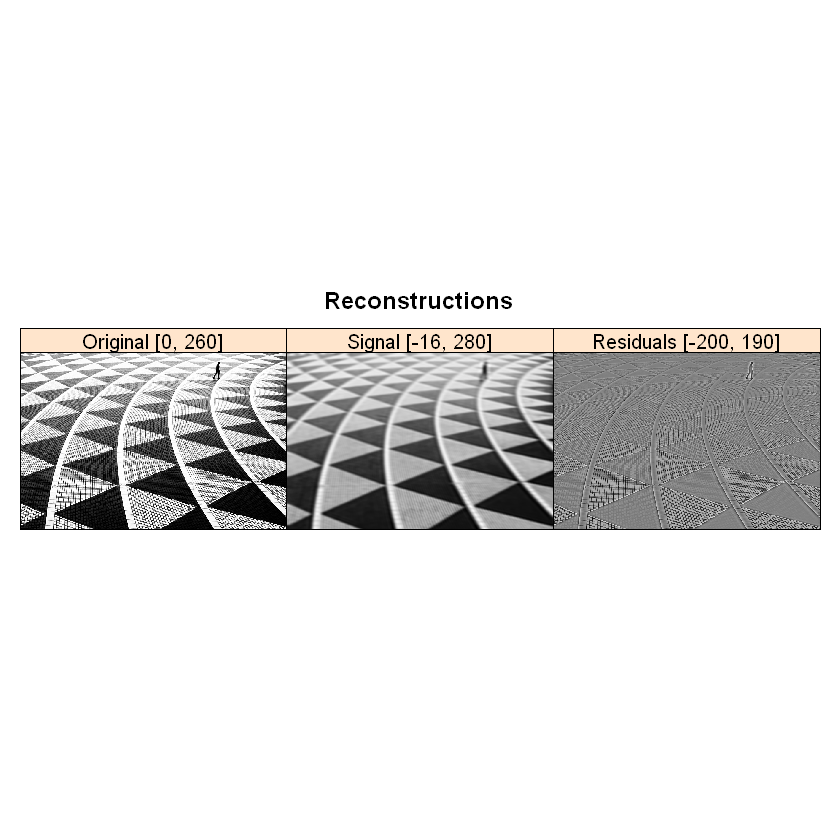

In [26]:
r <- reconstruct(s, groups = list(Signal = c(1:9, 22, 25)))
plot(r, cuts = 255, layout = c(3, 1))

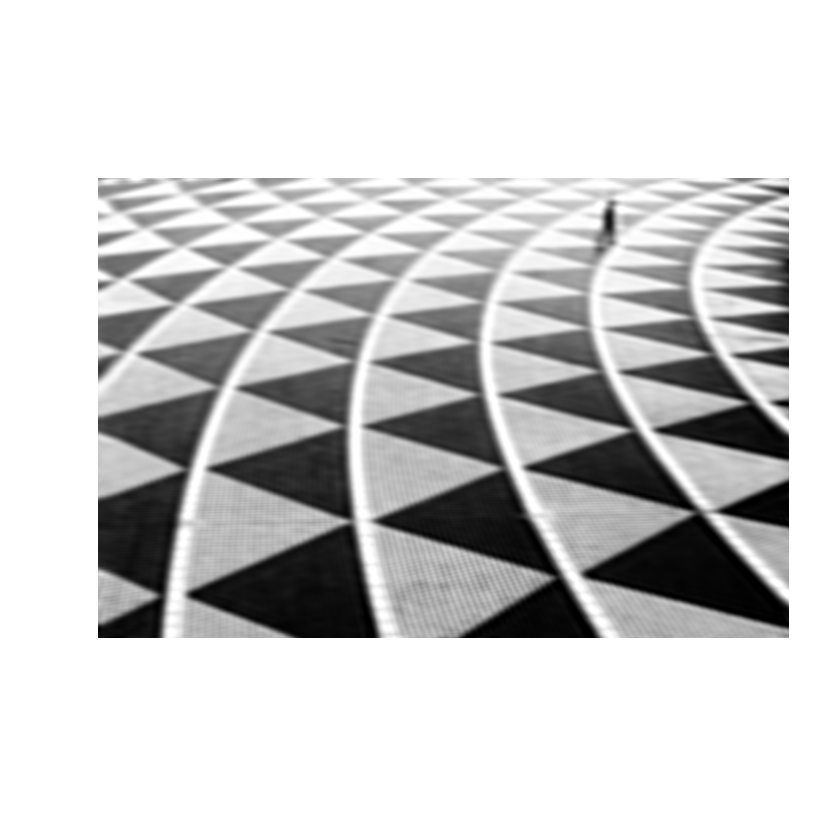

In [27]:
plot(matrix2img(r$Signal))

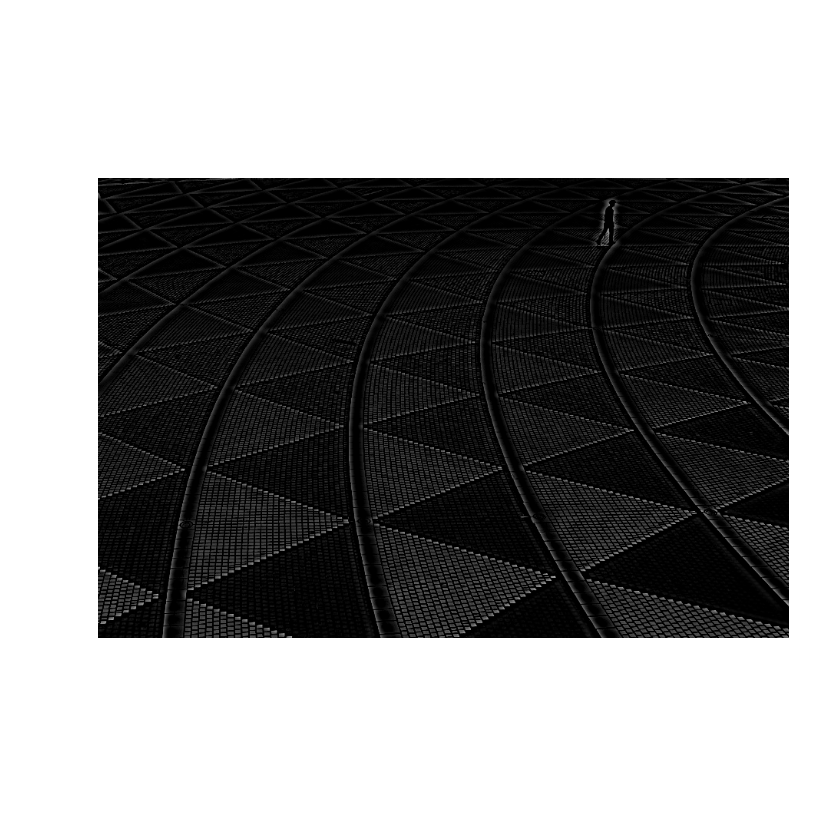

In [28]:
plot(matrix2img(mat - r$Signal))

По результирующей картинке не очень понятно удалось ли нам спраиться с задачей. С черными треугольниками это получилось сделать лучше, белые же просто сгладились. А вот на картинке с остатками видно, что четко выделяются маленькие квадраты. 

## MSSA

Смоделируем два ряда с похожей структурой

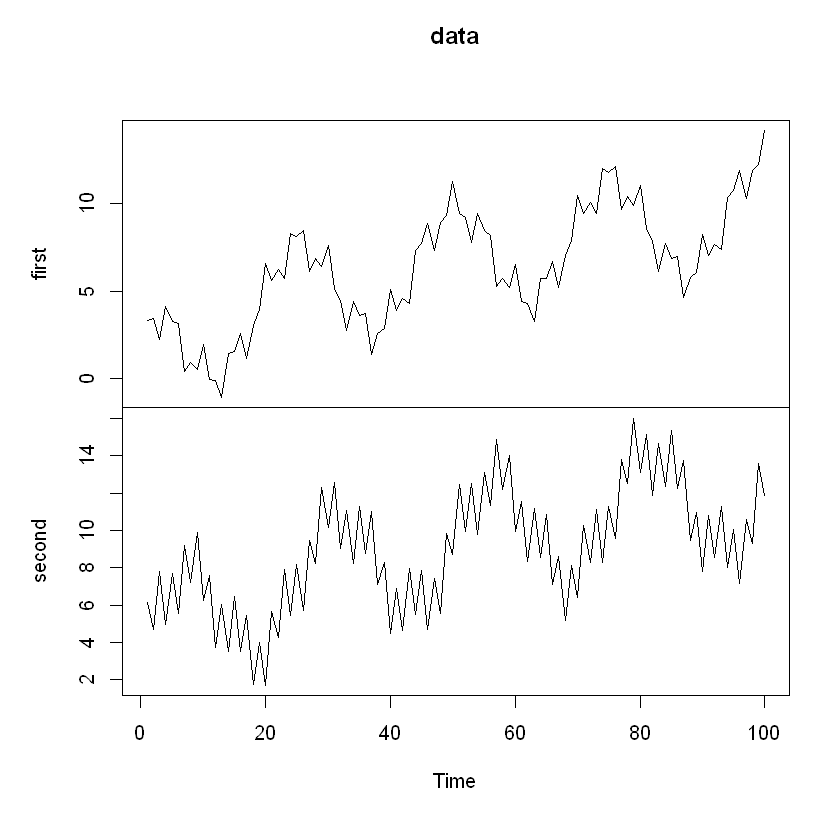

In [29]:
set.seed(2)
n <- 1:100
data.s <- n^(1/2)+3*cos(2*pi*(1/25)*n) + cos(2*pi*(1/5)*n) + rnorm(2)
data.s2 <- n^(1/2)+3*sin(2*pi*(1/25)*n) + sin(2*pi*(1/7)*n)+2 + rnorm(2)
data <- ts(data.frame(first = data.s, second = data.s2))
plot(data)

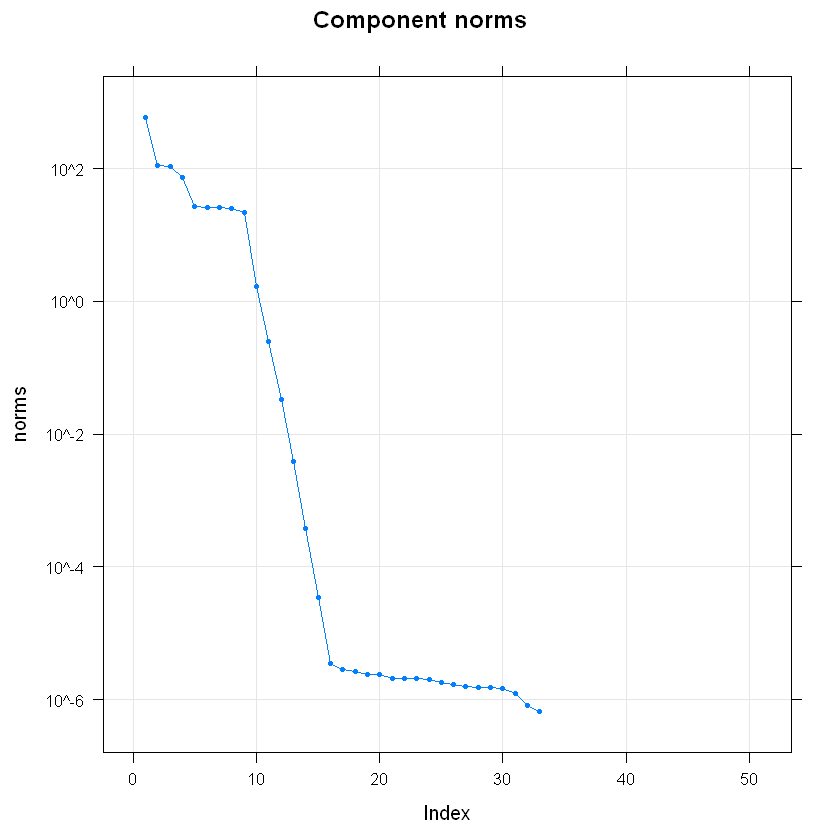

In [30]:
L <- 50
ms <- ssa(data, L = L, kind = "mssa")
plot(ms)

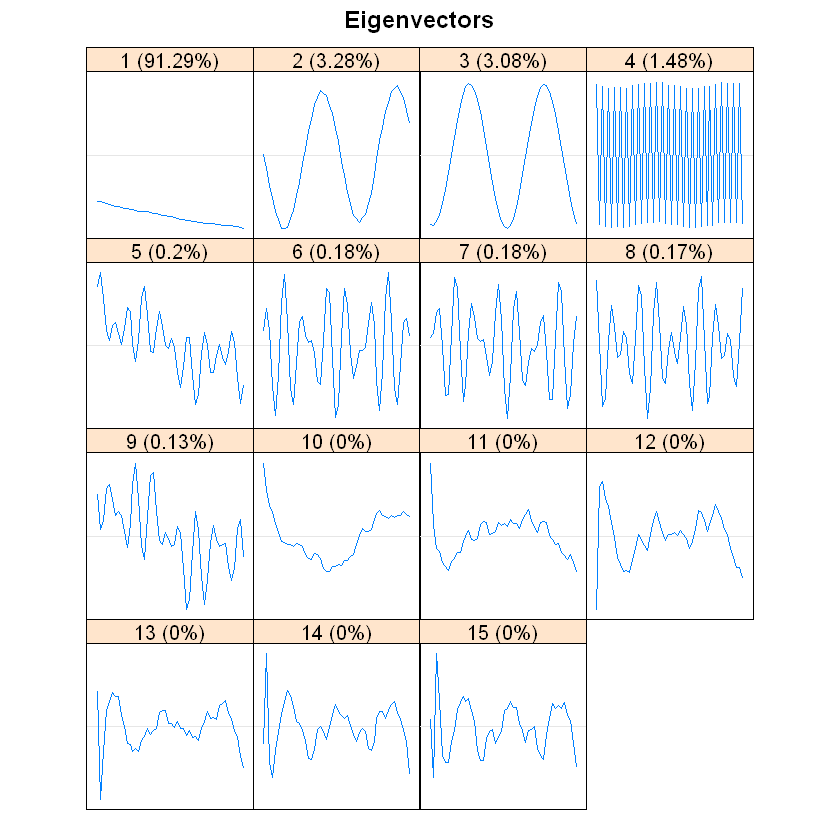

In [31]:
plot(ms, type = "vectors", idx = 1:15)

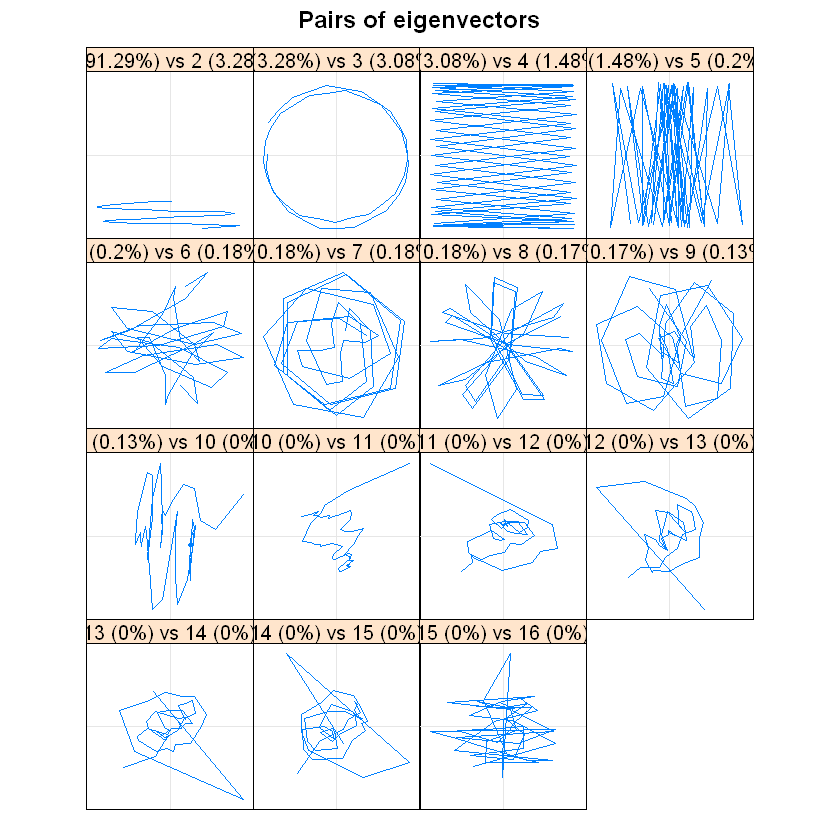

In [32]:
plot(ms, type = "paired", idx = 1:15)

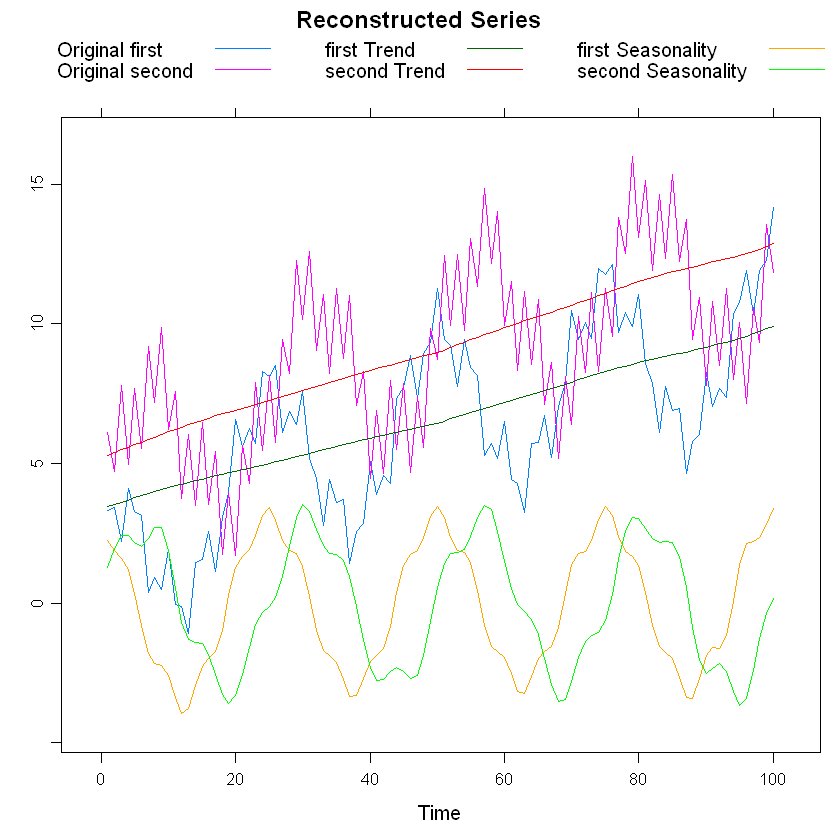

In [33]:
r <- reconstruct(ms, groups = list(Trend = c(1), Seasonality = c(2,3, 6, 7)))
plot(r, add.residuals = FALSE,
     plot.method = "xyplot",
     superpose = TRUE, auto.key = list(columns = 3))

### Реальные данные

In [34]:
data("AustralianWine", package = "Rssa")
wine <- window(AustralianWine, end = time(AustralianWine)[174])

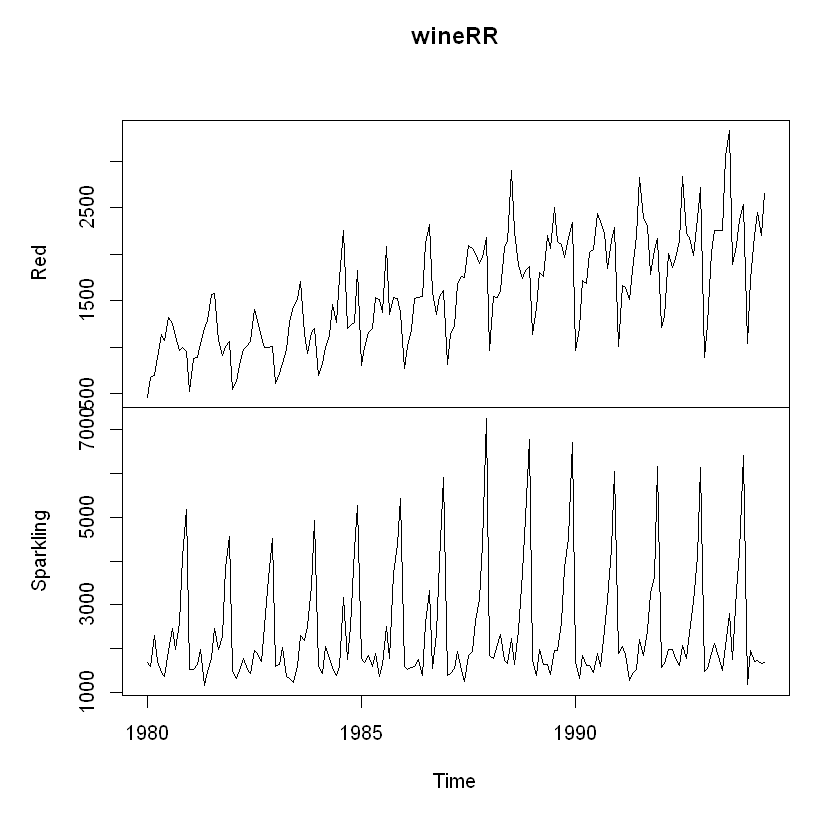

In [35]:
wineRR <- wine[, c("Red", "Sparkling")]
L <- 84
s.wineRR <- ssa(wineRR, L = L, kind = "mssa")
plot(wineRR)

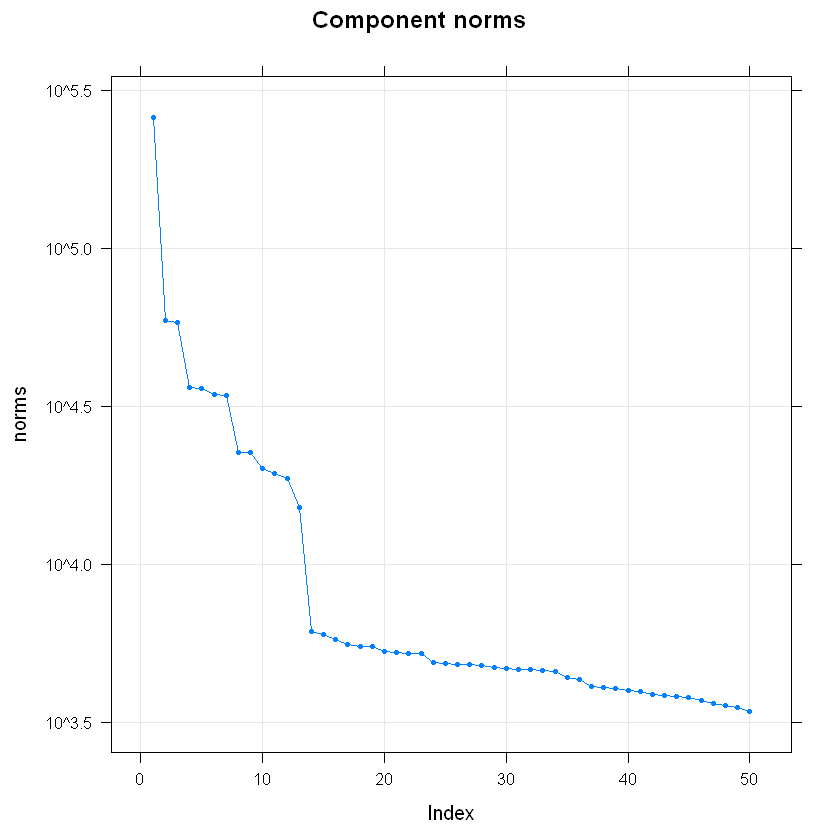

In [36]:
plot(s.wineRR)

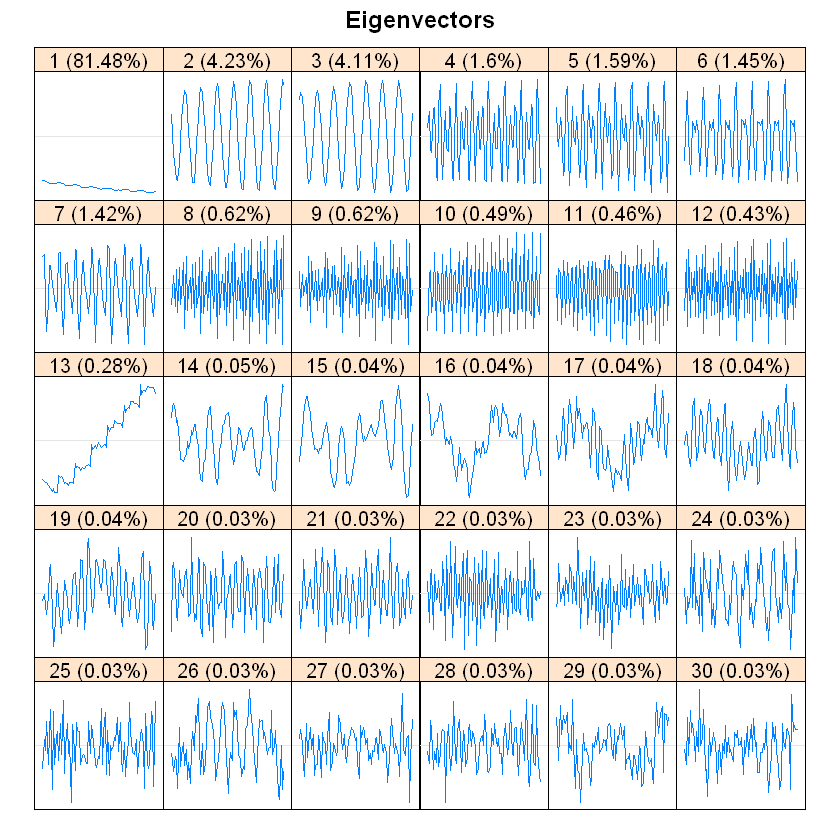

In [37]:
plot(s.wineRR, type = "vectors", idx = 1:30)

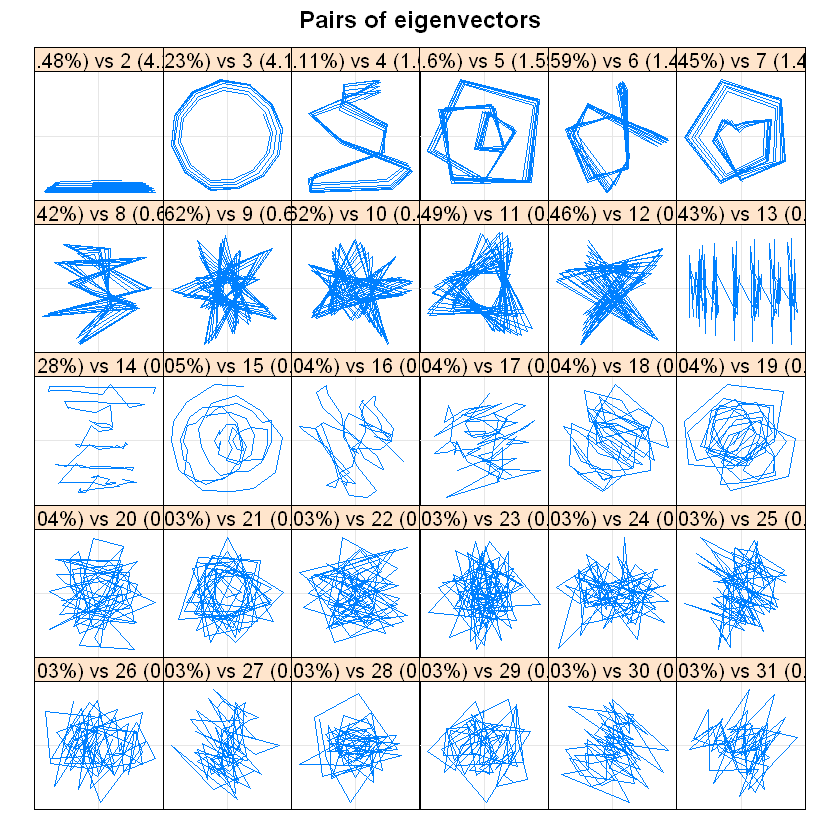

In [38]:
plot(s.wineRR, type = "paired", idx = 1:30)

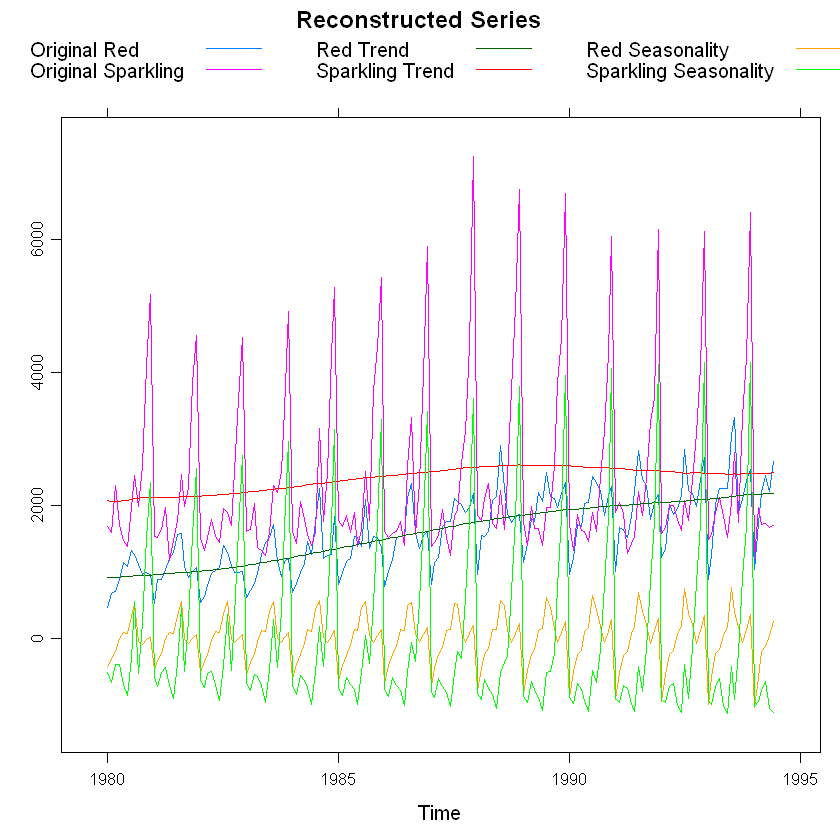

In [39]:
r.wineRR <- reconstruct(s.wineRR,
                             groups = list(Trend = c(1, 13),
                                Seasonality = c(2:12)))
plot(r.wineRR, add.residuals = FALSE,
     plot.method = "xyplot",
     superpose = TRUE, auto.key = list(columns = 3))